In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import ujson as json
import torch


from tqdm import tqdm
import numpy as np
from safetensors import safe_open
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
# Set font globally to Times New Roman
plt.rcParams['font.family'] = 'DejaVu Serif'
fontsize = 19


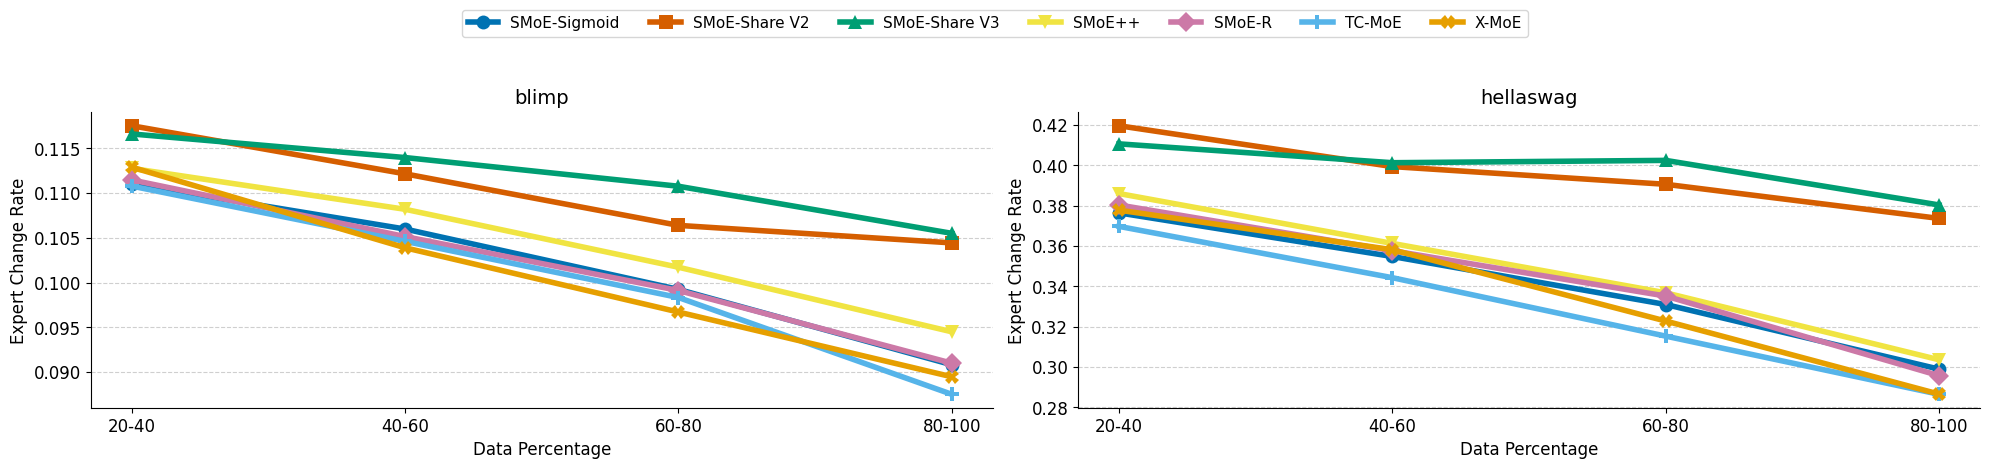

Saved to /cm/shared/anonymous_h100/LibMoE/evaluate/analysis/libmoev2/expert_change_rates.pdf


In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Plot expert-change rates of multiple MoE variants on four multimodal benchmarks.
‒ Colour-blind friendly palette (Okabe-Ito)
‒ Uniform X-axis labels: 20-40 · 40-60 · 60-80 · 80-100
‒ No black border around markers.

Author: Nam (2025-07-21)
"""
import json
from itertools import cycle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# ========== 1. CẤU HÌNH ========== #
FIG_W, FIG_H        = 20, 4          # figure size (inch)
FONTSIZE_TITLE      = 14
FONTSIZE_LABEL      = 12
FONTSIZE_LEGEND     = 11

root_paths = "/cm/archive/anonymous_new/revise_checkpoints/Xphi35-siglip224/SMOE/665K36"
model_list = [
    "Full_smoe_sigmoidgating",
    "Full_smoe_share",
    "Full_smoe_sharev3",
    "Full_smoe_plus_plus",
    "Full_smoe",
    "Full_smoe_tcmoe",
    "Full_xmoe",
]
datas = ["blimp", "hellaswag"]

pretty_name = {
    "Full_smoe":               "SMoE-R",
    "Full_smoe_share":         "SMoE-Share V2",
    "Full_smoe_sharev3": "SMoE-Share V3",
    "Full_smoe_sigmoidgating": "SMoE-Sigmoid",
    "Full_smoe_plus_plus":     "SMoE++",
    "Full_smoe_tcmoe":         "TC-MoE",
    "Full_xmoe":               "X-MoE",
}

# ---------- Nhãn X cố định ---------- #
x_labels = ["20-40", "40-60", "60-80", "80-100"]
x_pos    = np.arange(len(x_labels))        # [0, 1, 2, 3]

# ========== 2. NẠP & TÍNH GIÁ TRỊ ========== #
def load_all_scores() -> dict:
    """Trả về data_agg[data][model] = {percent: {layer: [score,…]}}"""
    data_agg = {d: {} for d in datas}
    print(data_agg)
    for dname in datas:
        for m in model_list:
            
            _new = m.replace("revise_", "")
            print(m)
            jpath = (Path(root_paths) / _new / "analysts" /
                     f"{dname}_score_selected_final.json")
            if not jpath.is_file():
                raise FileNotFoundError(jpath)
            with open(jpath) as f:
                raw = json.load(f)
            # print(m)
            # print(raw[m])
            try:
                data_agg[dname][_new] = raw[m]
            except:
                data_agg[dname][_new] = raw["revise_" + m]
    return data_agg




with open("/cm/shared/anonymous_h100/LibMoE/evaluate/analysis/results/router_change_rate_158m_pretrain.json", "r") as f:
    plot_values = json.load(f)
# ========== 3. MÀU & MARKER (Okabe-Ito) ========== #
cvd_palette = [
    "#0072B2", "#D55E00", "#009E73", "#F0E442",
    "#CC79A7", "#56B4E9", "#E69F00", "#000000",
]
markers = cycle(["o", "s", "^", "v", "D", "P", "X", "*"])

method_order  = model_list
method2color  = {m: cvd_palette[i % len(cvd_palette)]
                 for i, m in enumerate(method_order)}
method2marker = {m: next(markers) for m in method_order}

# ========== 4. VẼ HÌNH ========== #
fig, axes = plt.subplots(1, 2, figsize=(FIG_W, FIG_H))

title_map = {
    "mme": "MME",
    "mmmu_val": "MMMU-Val",
    "mmstar": "MMStar",
    "mathvista_testmini": "MathVista-Mini",
}

for i, dname in enumerate(datas):
    ax = axes[i]
    for m in method_order:
        # print(plot_values[dname][m])
        try:
            ax.plot(
                x_pos,
                plot_values[dname][m].values(),
                label=pretty_name.get(m, m),
                color=method2color[m],
                marker=method2marker[m],
                linewidth=4,
                markersize=10,
                markeredgewidth=0,          # bỏ viền
            )
        except:
            print(dname, m)
            print(plot_values[dname][m].values())

    ax.set_title(title_map.get(dname, dname), fontsize=FONTSIZE_TITLE)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, fontsize=FONTSIZE_LABEL)
    ax.set_xlabel("Data Percentage", fontsize=FONTSIZE_LABEL)
    # if i == 0:
    ax.set_ylabel("Expert Change Rate", fontsize=FONTSIZE_LABEL)
    ax.yaxis.grid(True, linestyle="--", alpha=.6)
    ax.tick_params(axis="y", labelsize=FONTSIZE_LABEL)
    ax.spines[["right", "top"]].set_visible(False)

# ---------- 5. LEGEND ---------- #
handles, labels = [], []
for m in method_order:
    handles.append(plt.Line2D(
        [], [], linestyle="-", linewidth=4,
        color=method2color[m], marker=method2marker[m],
        markersize=10, markeredgewidth=0,
        label=pretty_name.get(m, m)))
    labels.append(pretty_name.get(m, m))

fig.legend(handles, labels, loc="upper center",
           ncol=len(method_order), fontsize=FONTSIZE_LEGEND,
           bbox_to_anchor=(0.5, 1.18))

plt.tight_layout()
out_path = Path("expert_change_rates.pdf")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved to {out_path.resolve()}")


In [4]:
plot_values

{'blimp': {'Full_smoe': {'40000': 0.11146875,
   '60000': 0.10513541666666666,
   '80000': 0.09910416666666666,
   '100000': 0.09097916666666667},
  'Full_xmoe': {'40000': 0.11289583333333333,
   '60000': 0.10388541666666666,
   '80000': 0.09669791666666666,
   '100000': 0.08945833333333333},
  'Full_smoe_sigmoidgating': {'40000': 0.111,
   '60000': 0.10597916666666667,
   '80000': 0.09922916666666666,
   '100000': 0.09080208333333334},
  'Full_smoe_plus_plus': {'40000': 0.11276041666666667,
   '60000': 0.1081875,
   '80000': 0.10170833333333333,
   '100000': 0.09448958333333334},
  'Full_smoe_share': {'40000': 0.11752777777777777,
   '60000': 0.1121527777777778,
   '80000': 0.10638888888888888,
   '100000': 0.10443055555555554},
  'Full_smoe_sharev3': {'40000': 0.11661111111111112,
   '60000': 0.11397222222222222,
   '80000': 0.1107638888888889,
   '100000': 0.1055},
  'Full_smoe_tcmoe': {'40000': 0.11078125,
   '60000': 0.10460416666666666,
   '80000': 0.09832291666666666}},
 'hellas